In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import sys
import seaborn as sns
import random 
import cartopy as cp
import stormeunice as eun
import multiprocessing
import glob
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.transforms as mtransforms

sys.path.append('/home/e/ermis/moarpalettes')
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")
%matplotlib inline

random.seed(10)

# Data import and pre-processing

In [2]:
# Import track data
P1 = multiprocessing.Pool(40)
ifs_tracks = P1.map(eun.lagrangian.Lagrange.import_medr_tracks_TE, 
                    glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))
P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

# add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',
                        skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

eunice_track = era_track.query('track_id==5')

In [3]:
ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min))
eunice_filter = eunice_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min)).iloc[0]

# starttime criterion - must be detected within 12 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - eunice_filter.date).dt.total_seconds().abs()<(12*60*60)
# starting location criterion - must start within 10 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon-eunice_filter.lon)**2+(ifs_tracks_filter.lat-eunice_filter.lat)**2)<10
# depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]
ifs_eunice_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

In [4]:
# For members with more than one Eunice-like track: keep the ones with the longest track? 
multi_track_members = ifs_eunice_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

for idx in multi_track_members.index:
    track_dists = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(lambda x: eun.lagrangian.Lagrange.eunice_dist(x,eunice_track=eunice_track))
    num_reject = track_dists.idxmax()
    ifs_eunice_list_idx = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    ifs_eunice_list = ifs_eunice_list.drop(ifs_eunice_list_idx)

In [5]:
ERA5_tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/ERA5/EU025/sfc/2022.h5')
ERA5_eunice_track = ERA5_tracks.query('uid=="202202079"')

ERA5_data = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc').sel(time=ERA5_eunice_track.date.values)
ERA5_data['centroid_lon'] = ('time',(ERA5_eunice_track.long*4).round()/4)
ERA5_data['centroid_lat'] = ('time',(ERA5_eunice_track.lat*4).round()/4)

ERA5_eunice_stormframe = ERA5_data.groupby('time').apply(eun.lagrangian.Lagrange.lagrangian_frame)

In [6]:
%%capture 
# Ignore outputs

# Import field data, Lagrangian fram
curr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/*.nc',
                              preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                              combine='nested',
                              concat_dim=['inidate'],
                              parallel=True, 
                              engine='netcdf4')
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')

In [7]:
curr_storms

,Array,Chunk
Bytes,129.75 MiB,25.63 kiB
Shape,"(3, 1, 48, 36, 81, 81)","(1, 1, 1, 1, 81, 81)"
Count,61575 Tasks,5184 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,129.75 MiB,25.63 kiB
Shape,"(3, 1, 48, 36, 81, 81)","(1, 1, 1, 1, 81, 81)"
Count,61575 Tasks,5184 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


# Calculate statistics

In [8]:
ifs_eunice_list_stats = ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])].groupby(['experiment','inidate','number','track_id']).agg(dict(msl=min,date=min,vo=max)).reset_index()
ifs_eunice_list_stats['date'] = (ifs_eunice_list_stats.date - eunice_filter.date).dt.total_seconds()/(3600*24)

In [9]:
ifs_eunice_list_stats = ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])].groupby(['experiment','inidate','number','track_id']).agg(dict(msl=min,date=min,vo=max)).reset_index()
ifs_eunice_list_stats['date'] = (ifs_eunice_list_stats.date - eunice_filter.date).dt.total_seconds()/(3600*24)

In [10]:
# Add wind speed maxima
curr_max_winds = curr_storms.ws100.max(dim=['storm_lat','storm_lon', 'timestep'], skipna=True).squeeze().to_dataframe().reset_index()
incr_max_winds = incr_storms.ws100.max(dim=['storm_lat','storm_lon', 'timestep'], skipna=True).squeeze().to_dataframe().reset_index()
pi_max_winds = pi_storms.ws100.max(dim=['storm_lat','storm_lon', 'timestep'], skipna=True).squeeze().to_dataframe().reset_index()

ifs_eunice_list_stats2 = ifs_eunice_list_stats.merge(curr_max_winds, how='outer', on=['inidate', 'experiment', 'number'])
ifs_eunice_list_stats2 = ifs_eunice_list_stats2.merge(incr_max_winds, how='outer')
ifs_eunice_list_stats2 = ifs_eunice_list_stats2.merge(pi_max_winds, how='outer')

In [11]:
# Add precipitation
curr_precip = curr_storms.mxtpr.max(dim=['storm_lat','storm_lon', 'timestep'], skipna=True).squeeze().to_dataframe().reset_index()
incr_precip = incr_storms.mxtpr.max(dim=['storm_lat','storm_lon', 'timestep'], skipna=True).squeeze().to_dataframe().reset_index()
pi_precip = pi_storms.mxtpr.max(dim=['storm_lat','storm_lon', 'timestep'], skipna=True).squeeze().to_dataframe().reset_index()

ifs_eunice_list_stats2a = ifs_eunice_list_stats2.merge(curr_precip, how='outer', on=['inidate', 'experiment', 'number'])

In [12]:
ifs_eunice_list_stats2a

,experiment,inidate,number,track_id,msl,date,vo,ws100,mxtpr
0,ENS,2022-02-10,2,4.0,96089.23,0.125,0.000684,47.302433,0.003365
1,ENS,2022-02-10,7,5.0,95267.41,-0.125,0.000431,45.509426,0.004373
2,ENS,2022-02-10,8,8.0,94715.62,0.125,0.000578,43.447388,0.004230
3,ENS,2022-02-10,11,4.0,97218.59,0.125,0.000416,32.389030,0.003915
4,ENS,2022-02-10,12,4.0,96371.38,-0.125,0.000591,40.140034,0.003686
...,...,...,...,...,...,...,...,...,...
588,pi,2022-02-10,49,NaN,NaN,NaN,NaN,NaN,NaN
589,pi,2022-02-16,3,NaN,NaN,NaN,NaN,NaN,NaN
590,pi,2022-02-16,30,NaN,NaN,NaN,NaN,NaN,NaN
591,pi,2022-02-16,38,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Add rest of precip data
ifs_eunice_list_stats2a = ifs_eunice_list_stats2a.merge(incr_precip, how='outer')
ifs_eunice_list_stats2a = ifs_eunice_list_stats2a.merge(pi_precip, how='outer')

In [14]:
# Convert units in vorticity and pressure and precip
ifs_eunice_list_stats2a['vo'] = ifs_eunice_list_stats2a['vo']*10**6
ifs_eunice_list_stats2a['msl'] = ifs_eunice_list_stats2a['msl']/100
ifs_eunice_list_stats2a['mxtpr'] = ifs_eunice_list_stats2a['mxtpr']*1000

In [15]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1 = np.radians(lat1)
        lat2 = np.radians(lat2)
        lon1 = np.radians(lon1)
        lon2 = np.radians(lon2)

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [16]:
def calculate_track_speed(input):  # new version
    smoothed_vo = input.groupby(['experiment','inidate','number','track_id']).rolling(3, center=True, min_periods=1).vo.mean()
    grouped = input.groupby(['experiment','inidate','number','track_id'])

    # go through all storms to calculate mean track speed around peak vo
    track_speed = []
    for name, group in grouped: 
        peak_vo = group.rolling(3, center=True).mean().vo.idxmax()
        peak_vo_datetime = group.date.loc[peak_vo] 
        tmp = group.where((group.date < (peak_vo_datetime-pd.Timedelta(12, unit='h'))) & (group.date >= (peak_vo_datetime+pd.Timedelta(12, unit='h'))))
        tmp = haversine(group.lat.shift(), group.lon.shift(), group.loc[1:, 'lat'], group.loc[1:, 'lon']).cumsum()
        track_speed.append(tmp.iloc[-1]/24)

    output = grouped.date.min().reset_index()
    output['track_speed'] = track_speed

    # calculatee full track time
    start_time = grouped.date.min().reset_index()
    end_time = grouped.date.max().reset_index()
    track_time = (end_time.date - start_time.date).astype('timedelta64[h]')
    output['track_time'] = track_time

    # calculate full track length
    track_dist = []
    for name, group in grouped:
        tmp = haversine(group.lat.shift(), group.lon.shift(),
                        group.loc[1:, 'lat'], group.loc[1:, 'lon']).cumsum()
        track_dist.append(tmp.iloc[-1])
    output['track_dist'] = track_dist
    return output

In [17]:
def calculate_deepenening_time(input):

    smoothed_vo = input.groupby(['experiment','inidate','number','track_id']).rolling(3, center=True, min_periods=1).vo.mean()
    max_vo = smoothed_vo.groupby(['experiment','inidate','number','track_id']).idxmax().reset_index()
    max_idx = []
    for i in range(len(max_vo)):
        max_idx.append(max_vo.vo[i][-1])  # TODO: Why at vo maximum
    start_time = input.groupby(['experiment','inidate','number','track_id']).date.min().reset_index()
    max_time = input.loc[max_idx].reset_index()
    dt = (max_time.date - start_time.date).astype('timedelta64[h]')
    output = start_time.copy(deep = True)
    output['deepening_time'] = dt
    return output

In [18]:
ifs_eunice_list_stats3 = pd.merge(ifs_eunice_list_stats2a, calculate_deepenening_time(ifs_eunice_list)
                                  .drop(columns = 'date'), how = 'outer', on = ['experiment','inidate','number','track_id'])
ifs_eunice_list_stats3 = pd.merge(ifs_eunice_list_stats3, calculate_track_speed(ifs_eunice_list)
                                  .drop(columns = 'date'),
                                  how='outer', on = ['experiment','inidate','number','track_id'])

/tmp/user/27529/ipykernel_2084267/1334334795.py:8: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date', 'experiment', 'inidate'], dtype='object')
  peak_vo = group.rolling(3, center=True).mean().vo.idxmax()
/tmp/user/27529/ipykernel_2084267/1334334795.py:8: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date', 'experiment', 'inidate'], dtype='object')
  peak_vo = group.rolling(3, center=True).mean().vo.idxmax()
/tmp/user/27529/ipykernel_2084267/1334334795.py:8: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns w

In [19]:
# def normalised_deepening_rate(input):
#     # group by track and calculate 24h pressure difference
#     grouped = input.groupby(['experiment','inidate','number','track_id'])
#     diff_msl = grouped.msl.diff('time', 6)
#     output = diff_msl
#     return output

In [75]:
input

,track_id,inidate,experiment,number,year,month,day,hour,i,j,lon,lat,msl,vo,expid,date
0,1,2022-02-14,ENS,25,2022,2,17,9,0,111,-27.00,45.75,100150.40,0.000130,1,2022-02-17 09:00:00
1,1,2022-02-14,ENS,25,2022,2,17,12,1,108,-26.75,46.50,99387.10,0.000238,1,2022-02-17 12:00:00
2,1,2022-02-14,ENS,25,2022,2,17,15,10,105,-24.50,47.25,99108.85,0.000457,1,2022-02-17 15:00:00
3,1,2022-02-14,ENS,25,2022,2,17,18,21,99,-21.75,48.75,98643.55,0.000504,1,2022-02-17 18:00:00
4,1,2022-02-14,ENS,25,2022,2,17,21,30,95,-19.50,49.75,97933.05,0.000611,1,2022-02-17 21:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5101,8,2022-02-10,pi,26,2022,2,19,0,87,40,-5.25,63.50,97509.29,0.000323,b2nq,2022-02-19 00:00:00
5102,8,2022-02-10,pi,26,2022,2,19,6,88,36,-5.00,64.50,97837.22,0.000289,b2nq,2022-02-19 06:00:00
5103,8,2022-02-10,pi,26,2022,2,19,12,96,33,-3.00,65.25,98208.47,0.000314,b2nq,2022-02-19 12:00:00
5104,8,2022-02-10,pi,26,2022,2,19,18,98,27,-2.50,66.75,98565.02,0.000297,b2nq,2022-02-19 18:00:00


In [33]:
tracks_longer_than_24hrs

,track_id,inidate,experiment,number,year,month,day,hour,i,j,lon,lat,msl,vo,expid,date
0,1,2022-02-14,ENS,25,2022,2,17,9,0,111,-27.00,45.75,100150.40,0.000130,1,2022-02-17 09:00:00
1,1,2022-02-14,ENS,25,2022,2,17,12,1,108,-26.75,46.50,99387.10,0.000238,1,2022-02-17 12:00:00
2,1,2022-02-14,ENS,25,2022,2,17,15,10,105,-24.50,47.25,99108.85,0.000457,1,2022-02-17 15:00:00
3,1,2022-02-14,ENS,25,2022,2,17,18,21,99,-21.75,48.75,98643.55,0.000504,1,2022-02-17 18:00:00
4,1,2022-02-14,ENS,25,2022,2,17,21,30,95,-19.50,49.75,97933.05,0.000611,1,2022-02-17 21:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5101,8,2022-02-10,pi,26,2022,2,19,0,87,40,-5.25,63.50,97509.29,0.000323,b2nq,2022-02-19 00:00:00
5102,8,2022-02-10,pi,26,2022,2,19,6,88,36,-5.00,64.50,97837.22,0.000289,b2nq,2022-02-19 06:00:00
5103,8,2022-02-10,pi,26,2022,2,19,12,96,33,-3.00,65.25,98208.47,0.000314,b2nq,2022-02-19 12:00:00
5104,8,2022-02-10,pi,26,2022,2,19,18,98,27,-2.50,66.75,98565.02,0.000297,b2nq,2022-02-19 18:00:00


In [42]:
grouped_tracks['msl'].apply(lambda x: x.diff(6)).reset_index().head(12)

/tmp/user/27529/ipykernel_2084267/3257605135.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grouped_tracks['msl'].apply(lambda x: x.diff(6)).reset_index().head(12)


,index,msl
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN
5,5,NaN
6,6,-3349.04
7,7,-2899.90
8,8,-2731.72
9,9,-2474.01


In [38]:
grouped_tracks['msl'].diff(6).head(12)

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
5         NaN
6    -3349.04
7    -2899.90
8    -2731.72
9    -2474.01
10   -1865.56
11   -1233.75
Name: msl, dtype: float64

In [54]:
tracks_longer_than_24hrs = grouped.filter(lambda x: len(x) > 6)
grouped_tracks = tracks_longer_than_24hrs.groupby(['experiment','inidate','number','track_id'])
grouped['msl'].apply(lambda x: x.diff(6)).reset_index()['msl']

/tmp/user/27529/ipykernel_2084267/3468007950.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grouped['msl'].apply(lambda x: x.diff(6)).reset_index()['msl']


0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
4968    -721.13
4969    1007.71
4970    2150.86
4971    2280.04
4972    2200.07
Name: msl, Length: 4973, dtype: float64

In [51]:
grouped.apply(lambda x: x.msl.diff(6)).reset_index().head(20)

,experiment,inidate,number,track_id,level_4,msl
0,ENS,2022-02-10,2,4,4583,NaN
1,ENS,2022-02-10,2,4,4584,NaN
2,ENS,2022-02-10,2,4,4585,NaN
3,ENS,2022-02-10,2,4,4586,NaN
4,ENS,2022-02-10,2,4,4587,NaN
5,ENS,2022-02-10,2,4,4588,NaN
6,ENS,2022-02-10,7,5,4864,NaN
7,ENS,2022-02-10,7,5,4865,NaN
8,ENS,2022-02-10,7,5,4866,NaN
9,ENS,2022-02-10,7,5,4867,NaN


In [62]:
grouped.filter(lambda x: len(x) > 6).groupby(['experiment','inidate','number','track_id'], group_keys=False).apply(lambda x: x.msl.diff(6)).reset_index().head(12)

,index,msl
0,4864,NaN
1,4865,NaN
2,4866,NaN
3,4867,NaN
4,4868,NaN
5,4869,NaN
6,4870,-4250.75
7,4871,-2558.27
8,4872,-1232.72
9,4873,519.74


In [60]:
input = ifs_eunice_list
# group by track and keep all columns
grouped = input.groupby(['experiment','inidate','number','track_id'], group_keys=False)

# filter pandas to select only ids with more than 6 points, calculate 24h pressure difference
# input['msl_diff'] = grouped['msl'].filter(lambda x: len(x) > 6).groupby(['experiment','inidate','number','track_id']).apply(lambda x: x.msl.diff(6)).reset_index()
# input['msl_diff'] = grouped.filter(lambda x: len(x) > 6).apply(lambda x: x.msl.diff(6)).reset_index()

input['msl_diff'] = grouped['msl'].apply(lambda x: x.diff(6)).reset_index()['msl']
# calculate maximum 24h pressure difference for each track, calculate bergeron deepening rate
# ndr = msl_diff.groupby(['experiment','inidate','number','track_id']).min().reset_index()
input.head(20)

,track_id,inidate,experiment,number,year,month,day,hour,i,j,lon,lat,msl,vo,expid,date,msl_diff
0,1,2022-02-14,ENS,25,2022,2,17,9,0,111,-27.00,45.75,100150.40,0.000130,1,2022-02-17 09:00:00,NaN
1,1,2022-02-14,ENS,25,2022,2,17,12,1,108,-26.75,46.50,99387.10,0.000238,1,2022-02-17 12:00:00,NaN
2,1,2022-02-14,ENS,25,2022,2,17,15,10,105,-24.50,47.25,99108.85,0.000457,1,2022-02-17 15:00:00,NaN
3,1,2022-02-14,ENS,25,2022,2,17,18,21,99,-21.75,48.75,98643.55,0.000504,1,2022-02-17 18:00:00,NaN
4,1,2022-02-14,ENS,25,2022,2,17,21,30,95,-19.50,49.75,97933.05,0.000611,1,2022-02-17 21:00:00,NaN
5,1,2022-02-14,ENS,25,2022,2,18,0,40,92,-17.00,50.50,97278.69,0.000650,1,2022-02-18 00:00:00,NaN
6,1,2022-02-14,ENS,25,2022,2,18,3,52,86,-14.00,52.00,96801.36,0.000629,1,2022-02-18 03:00:00,NaN
7,1,2022-02-14,ENS,25,2022,2,18,6,65,80,-10.75,53.50,96487.20,0.000536,1,2022-02-18 06:00:00,NaN
8,1,2022-02-14,ENS,25,2022,2,18,9,79,73,-7.25,55.25,96377.13,0.000406,1,2022-02-18 09:00:00,NaN
9,1,2022-02-14,ENS,25,2022,2,18,12,94,73,-3.50,55.25,96169.54,0.000325,1,2022-02-18 12:00:00,NaN


In [70]:
msl_diff

,experiment,inidate,number,track_id,level_4,msl
0,ENS,2022-02-10,7,5,4864,NaN
1,ENS,2022-02-10,7,5,4865,NaN
2,ENS,2022-02-10,7,5,4866,NaN
3,ENS,2022-02-10,7,5,4867,NaN
4,ENS,2022-02-10,7,5,4868,NaN
...,...,...,...,...,...,...
4940,pi,2022-02-16,49,1,3070,1696.38
4941,pi,2022-02-16,49,1,3071,1781.67
4942,pi,2022-02-16,49,1,3072,1686.20
4943,pi,2022-02-16,49,1,3073,1592.86


In [58]:
ndr

,experiment,inidate,number,track_id,level_4,msl
0,ENS,2022-02-10,7,5,4864,-4250.75
1,ENS,2022-02-10,8,8,5086,-5210.52
2,ENS,2022-02-10,12,4,4595,-214.15
3,ENS,2022-02-10,13,4,4605,-5117.90
4,ENS,2022-02-10,14,7,5016,-2894.14
...,...,...,...,...,...,...
247,pi,2022-02-16,44,1,2966,-2840.26
248,pi,2022-02-16,45,1,2988,-3340.47
249,pi,2022-02-16,46,1,3010,-2725.34
250,pi,2022-02-16,48,1,3033,-3666.44


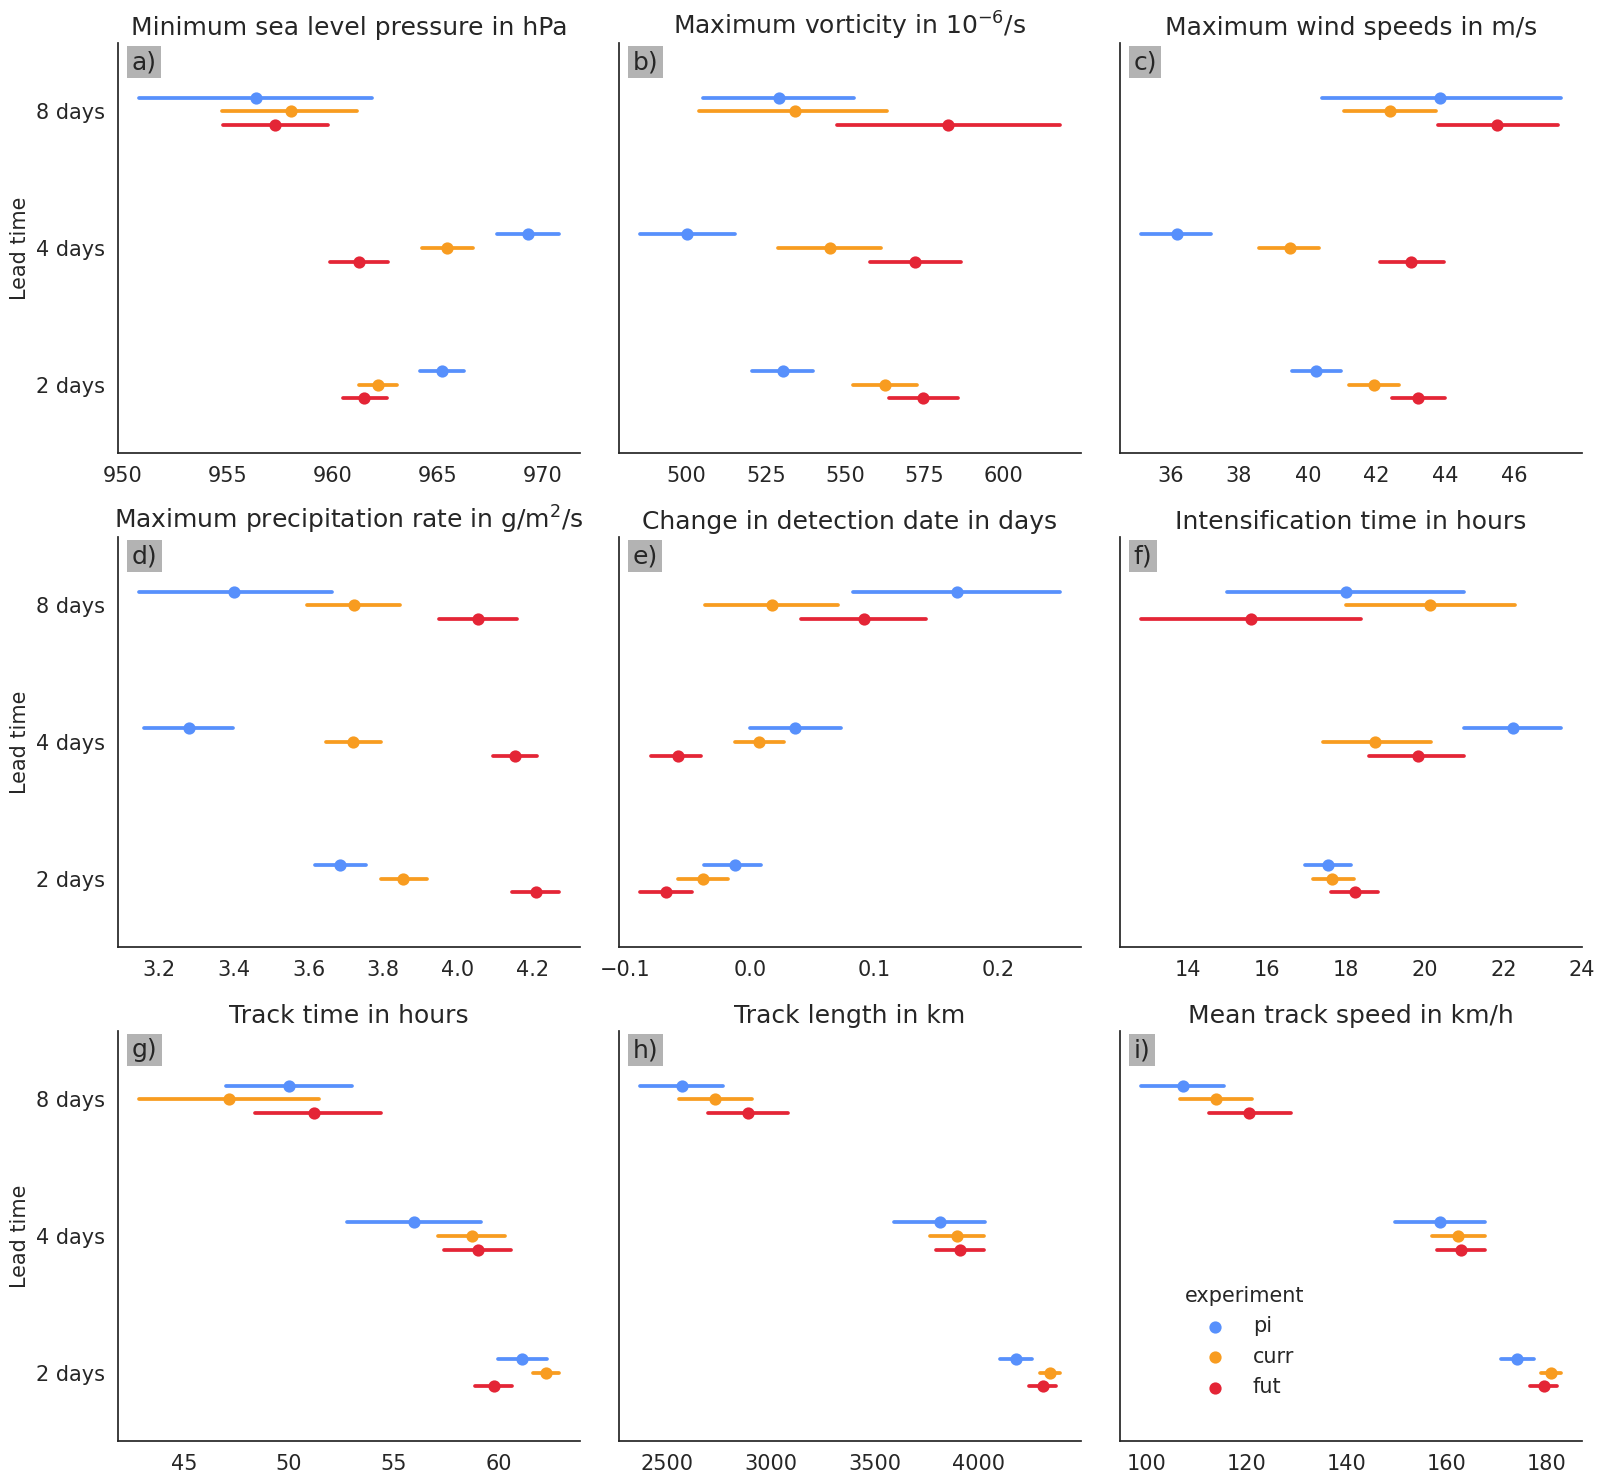

In [121]:
fs = 18  # fontsize
g = sns.catplot(data=ifs_eunice_list_stats3.set_index(['experiment','inidate'])
                .drop(['track_id', 'number'], axis=1).stack().astype(float)
                .reset_index()
                .rename({'level_2':'variable',0:'value'}, axis=1),
                        x='value',
                        col='variable',
                        y='inidate',
                        hue='experiment',
                        hue_order=['pi','ENS','incr'],
                        palette=get_palette.Petroff6().to_sn_palette(),
                        kind='point',
                        join=False,
                        dodge=0.2,
                        errorbar=('ci',66),
                        n_boot=10000,
                        sharex=False,
                        legend = True,
                        col_wrap=3, 
                        col_order=['msl', 'vo', 'ws100', 'mxtpr', 'date', 'deepening_time', 'track_time', 'track_dist', 'track_speed'])

g.axes[0].set_ylabel('Lead time', fontsize=fs-3)
g.axes[3].set_ylabel('Lead time', fontsize=fs-3)
g.axes[6].set_ylabel('Lead time', fontsize=fs-3)

inidates = ['8 days', '4 days', '2 days']
g.axes[0].set_yticklabels(inidates, fontsize=fs-3)
g.axes[3].set_yticklabels(inidates, fontsize=fs-3)

# g.axes[0].set_xticks([950, 955, 960, 965, 970, 975, 980])
# g.axes[0].set_xticklabels(['950','955', '960', '965', '970', '975', '980'])
g.axes[0].xaxis.set_major_formatter(FormatStrFormatter('%d'))

g.axes[0].set_title('Minimum sea level pressure in hPa', fontsize=fs)
g.axes[1].set_title(r'Maximum vorticity in 10$^{-6}$/s', fontsize=fs)
g.axes[2].set_title('Maximum wind speeds in m/s', fontsize=fs)
g.axes[3].set_title(r'Maximum precipitation rate in g/m$^2$/s', fontsize=fs)
g.axes[4].set_title('Change in detection date in days', fontsize=fs)
g.axes[5].set_title('Intensification time in hours', fontsize=fs)
g.axes[6].set_title('Track time in hours', fontsize=fs)
g.axes[7].set_title('Track length in km', fontsize=fs)
g.axes[8].set_title('Mean track speed in km/h', fontsize=fs)

g.axes[0].tick_params(axis='both', which='major', labelsize=fs-3)
g.axes[1].tick_params(axis='both', which='major', labelsize=fs-3)
g.axes[2].tick_params(axis='both', which='major', labelsize=fs-3)
g.axes[3].tick_params(axis='both', which='major', labelsize=fs-3)
g.axes[4].tick_params(axis='both', which='major', labelsize=fs-3)
g.axes[5].tick_params(axis='both', which='major', labelsize=fs-3)
g.axes[6].tick_params(axis='both', which='major', labelsize=fs-3)
g.axes[7].tick_params(axis='both', which='major', labelsize=fs-3)
g.axes[8].tick_params(axis='both', which='major', labelsize=fs-3)

trans = mtransforms.ScaledTranslation(10/72, -5/72, g.figure.dpi_scale_trans)
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)']
g.axes[0].text(0.0, 1.0, labels[0], transform=g.axes[0].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
g.axes[1].text(0.0, 1.0, labels[1], transform=g.axes[1].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
g.axes[2].text(0.0, 1.0, labels[2], transform=g.axes[2].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
g.axes[3].text(0.0, 1.0, labels[3], transform=g.axes[3].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
g.axes[4].text(0.0, 1.0, labels[4], transform=g.axes[4].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
g.axes[5].text(0.0, 1.0, labels[5], transform=g.axes[5].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
g.axes[6].text(0.0, 1.0, labels[6], transform=g.axes[6].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
g.axes[7].text(0.0, 1.0, labels[7], transform=g.axes[7].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
g.axes[8].text(0.0, 1.0, labels[8], transform=g.axes[8].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

g.set_axis_labels("")
sns.move_legend(g, "upper left", bbox_to_anchor=(.73, .15), title='experiment', fontsize=fs-3, frameon=False, title_fontsize=fs-3,)
# g.axes[7].legend(['pi', 'curr', 'fut'], title = "experiment", fontsize=fs-3, frameon=False, title_fontsize=fs-3, loc='best')
new_labels = ['pi', 'curr', 'fut']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
plt.tight_layout()


plt.savefig('figures/PAPER3_surface_langrangians_stats.png')
plt.savefig('figures/PAPER3_surface_langrangians_stats.pdf')